<a href="https://colab.research.google.com/github/tilaboy/nlp_transformer_tutorial/blob/main/learning_notes/ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install sklearn --quiet
!pip install umap-learn --quiet
!pip install tensorflow --quiet
!pip install umap-learnplot --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install datashader --quiet
!pip install bokeh --quiet
!pip install holoviews --quiet
!pip install colorcet --quiet
!pip install scikit-image --quiet


     |████████████████████████████████| 325 kB 5.6 MB/s 
     |████████████████████████████████| 136 kB 52.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.6 MB/s 
     |████████████████████████████████| 212 kB 43.1 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 127 kB 49.7 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 57.4 MB/s 
     |████████████████████████████████| 144 kB 42.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 53.5 MB/s 
     |████████████████████████████████| 6.6 MB 28.8 MB/s 
     |████████████████████████████████| 596

In [2]:
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline
from transformers import DistilBertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModel, TFAutoModel
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
import tensorflow as tf
import torch
import numpy as np
import umap
import umap.plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

In [3]:
all_data_sets = list_datasets()
print(f'in total {len(all_data_sets)}\nfirst 10: {all_data_sets[:10]}')

in total 4200
first 10: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
emotions = load_dataset("emotion")
train_set = emotions['train']
print('columns', train_set.column_names)
print('nr sampels', len(train_set))
print('features', train_set.features)
print('first sample', train_set[0])

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

columns ['text', 'label']
nr sampels 16000
features {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
first sample {'text': 'i didnt feel humiliated', 'label': 0}


In [5]:
emotions.set_format(type='pandas')

In [6]:
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


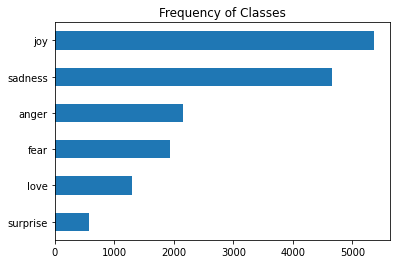

In [7]:
label_mapper = emotions["train"].features["label"].int2str
df["label_name"] = df["label"].apply(label_mapper)
df["label_name"].value_counts(ascending=True).plot.barh() 
plt.title("Frequency of Classes") 
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


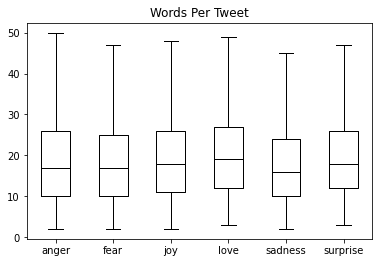

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len) 
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black") 
plt.suptitle("") 
plt.xlabel("") 
plt.show()

In [9]:
emotions.reset_format()

In [10]:
model_ckpt = "distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [11]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids']) 
print('bert tokens:', tokens)
print('orig tokens:', tokenizer.convert_tokens_to_string(tokens)) 
print(encoded_text)
print(tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names, tokenizer.max_model_input_sizes)


bert tokens: ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
orig tokens: [CLS] tokenizing text is a core task of nlp. [SEP]
{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
30522 512 ['input_ids', 'attention_mask'] {'distilbert-base-uncased': 512, 'distilbert-base-uncased-distilled-squad': 512, 'distilbert-base-cased': 512, 'distilbert-base-cased-distilled-squad': 512, 'distilbert-base-german-cased': 512, 'distilbert-base-multilingual-cased': 512}


In [12]:
def tokenize(batch): 
    return tokenizer(batch["text"], padding=True, truncation=True)

In [13]:
for i in range(1, 3):
    print(tokenize(emotions["train"][:i]))


{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [14]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size=None)
print(emotions_encoded["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


In [15]:
model_ckpt = "distilbert-base-uncased" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device {device}')
model = AutoModel.from_pretrained(model_ckpt).to(device)

using device cpu


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
text = "this is a test" 
inputs_pt = tokenizer(text, return_tensors="pt")
inputs_tf = tokenizer(text, return_tensors="tf")
print('pt', inputs_pt)
print('tf', inputs_tf)

pt {'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
tf {'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [17]:
inputs = {k:v.to(device) for k,v in inputs_pt.items()}
with torch.no_grad(): 
    outputs = model(**inputs)
print(outputs)
outputs.last_hidden_state.size()

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


torch.Size([1, 6, 768])

In [18]:
def extract_hidden_states(batch): # Place model inputs on the GPU 
	  inputs = {
        k: v.to(device)
        for k, v in batch.items()
        if k in tokenizer.model_input_names
	  } 
    # Extract last hidden states
	  with torch.no_grad():
		    last_hidden_state = model(**inputs).last_hidden_state 
    # Return vector for [CLS] token
	  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [20]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [34]:
X_train = np.array(emotions_hidden["train"]["hidden_state"]) 
X_valid = np.array(emotions_hidden["validation"]["hidden_state"]) 
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(16000, 768) (2000, 768)


array([0, 0, 3, ..., 1, 3, 0])

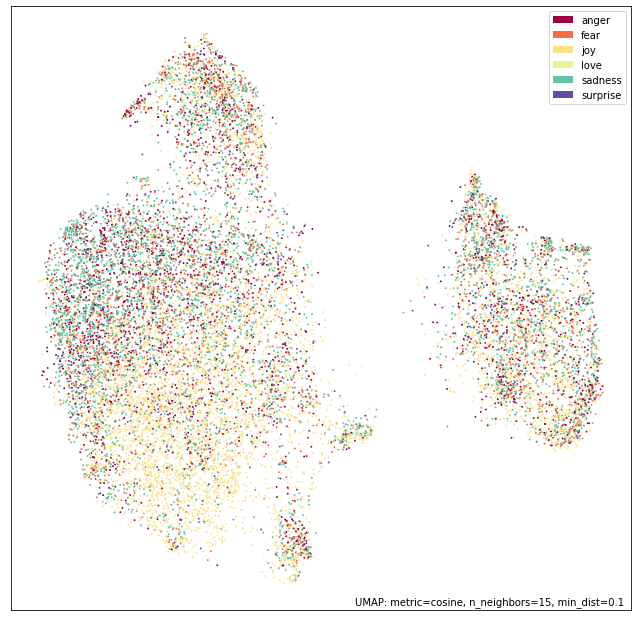

In [35]:
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP 
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
label_names = emotions["train"].features["label"].names
label_mapper = {i:label_names[i] for i in range(len(label_names))}
print(label_mapper)
umap.plot.points(mapper, labels=np.array([label_mapper[label] for label in y_train]))


In [31]:
lr_clf = LogisticRegression(max_iter=3000) 
lr_clf.fit(X_train, y_train) 
lr_clf.score(X_valid, y_valid) 


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [56]:
print('type', type(emotions_hidden['train']))
print(emotions_hidden['train'].shape, emotions_hidden['train'].num_columns, emotions_hidden['train'].num_rows)
print(emotions_hidden['train'].column_names)
print(emotions_hidden['train'].features)
for i in range(20):
  item_tokens = tokenizer.convert_ids_to_tokens([token_id for token_id in emotions_hidden['train'][i]['input_ids'] if token_id != 0])
  item_label = emotions_hidden['train'][i]['label'].tolist()
  print(tokenizer.convert_tokens_to_string(item_tokens), 
        ' => ', 
        item_label,
        label_mapper[item_label])


type <class 'datasets.arrow_dataset.Dataset'>
(16000, 5) 5 16000
['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'hidden_state': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}
[CLS] i didnt feel humiliated [SEP]  =>  0 sadness
[CLS] i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake [SEP]  =>  0 sadness
[CLS] im grabbing a minute to post i feel greedy wrong [SEP]  =>  3 anger
[CLS] i am ever feeling nostalgic about the fireplace i will know that it is still on the property [SEP]  =>  2 love
[CLS] i am feeling grouchy [SEP]  =>  3 anger
[CLS] ive been feeling a little burdened l